# Data Exploration for a Machine Learning Stock Predictor

In [123]:
# import needed libraries
import os
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions
---

Global functions intended to make computations easier. These are also developed with the intention to be used in the final code implimentaion

In [124]:

################################################
# Data Gathering Helpers
################################################
def path_to_data(ticker, base_dir='data'):
    return os.path.join(base_dir, '{}.csv'.format(ticker))

def fetch_data(ticker_list, dates):
    df = pd.DataFrame(index=dates)
    
    if 'SPY' not in ticker_list:
        ticker_list.insert(0, 'SPY')
        
    for ticker in range(0, len(ticker_list)):
        df_temp = pd.read_csv(
            path_to_data(ticker_list[ticker]), 
            usecols=['Date', 'Adj Close'], 
            index_col='Date', 
            parse_dates=True, 
            na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : ticker_list[ticker]})
        df = df.join(df_temp)
    
    df = df.dropna(subset=['SPY'])
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

################################################
# STATS Helpers
################################################
def normalize_data(df):
    return df/df.iloc[0,:]

def get_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (daily_returns[1:] / daily_returns[0:-1].values) - 1
    daily_returns.iloc[0, : ] = 0
    return daily_returns

# rolling stats
def get_rolling_mean(vals, window=20):
    return vals.rolling(window,center=False).mean()

def get_rolling_std(vals, window=20):
    return vals.rolling(window,center=False).std()

def get_bollinger_bands(rolling_mean, rolling_std):
    lower_band = rolling_mean - (rolling_std * 2)
    upper_band = rolling_mean + (rolling_std * 2)
    return lower_band, upper_band

def get_bollinger_ratios(series, sma, r_std, window=20):
    bb = series.copy()
    bb[window:] = (bb[window:] - sma[window:]) / (2 * r_std[window:])
    return bb[window:]

def get_momentum(df, window=20):
    momentum = df.copy()
    momentum[window:] = (momentum[window:] / momentum[0:-window].values) - 1
    return momentum[window:]

def get_sma_ratio(df, window=20):
    sma = df.copy()
    sma[window:] = (sma[window:] / sma[0:-window].mean()) - 1
    return sma[window:]

def normalize_feature(series):
    return (series - series.mean())/series.std()

################################################
# Graph Plotting Helpers
################################################
def plot_hist_with_stats(df, bins=10, title=''):
    
    mean = df.mean()
    std = df.std()
    
    df.hist(bins=bins)
    plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
    plt.axvline(mean + std, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - std, color='r', linestyle='dashed', linewidth=2)
    plt.show()

def plot_hist_multi(df, bins=10, title=''):
    for stock in df:
        df[stock].hist(bins=bins, label=stock, alpha = 0.5)
    plt.legend(loc='best')
    plt.show()
    
def print_bollinger_bands(series, rolling_mean, lower_band, upper_band, label=''):
    val = ax = series.plot(title='Bollinger Bands: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    ub = upper_band.plot(label='Upper Band', ax=ax)
    lb = lower_band.plot(label='Lower Band', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_momentum(series, rolling_mean, label=''):
    val = ax = series.plot(title='Momentum: ' + label, label='Prices', fontsize=10)
    rm = rolling_mean.plot(label='Rolling Mean', ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='best')
    plt.show()
    
def plot_data(df, title='Stock Prices', xlabel='Date', ylabel='Price'):
    ax = df.plot(title=title, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
################################################
# Machine Learning Models
################################################

class KnnLearner:
    def __init__(self, n_neighbors, weights='distance'):
        self.n_neighbors = n_neighbors
        self.clf = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
            
    def train(self, X, y):
        self.clf.fit(X, y)
    
    def score(self, X, y):
        return self.clf.score(X, y)
    
    def query(self, X):
        return self.clf.predict(X)
    
#class RegressionLearner:
#    def __init__(self):
#        self.clf = BayesianRidge()
            
#    def train(self, X, y):
#        self.clf.fit(X, y)
    
#    def query(self, X):
#        return self.clf.predict(X) 
    
#    def score(self, X, y):
#        return self.clf.score(X, y) 

## Process Data for Selected Stocks
---

In [156]:
# use two years of dates for data exploration
dates = pd.date_range('2015-07-14', '2017-07-14')

ticker = 'SPY'

# These will be the tickers we will be working with to build our model
# SPY is added as a benchmark model. 
tickers = [ticker]


df_explore = fetch_data(tickers, dates)
print df_explore.head(n=5)

                   SPY
2015-07-14  210.679993
2015-07-15  210.610001
2015-07-16  212.300003
2015-07-17  212.479996
2015-07-20  212.589996


## Visualize the Data of the Selected Stocks
---


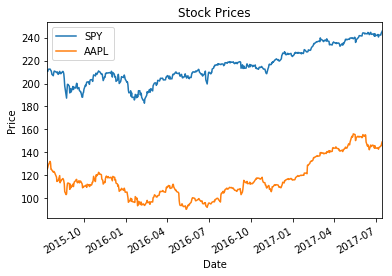

In [126]:
plot_data(df_explore)

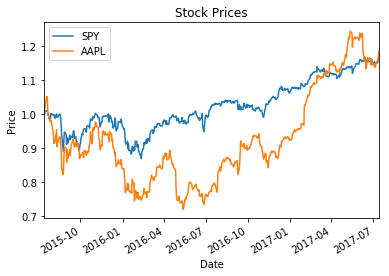

In [127]:
normalized_data = normalize_data(df_explore)
plot_data(normalized_data)

## Global Stats
---

Global stats of the stocks we are interested in

---

In [128]:
print 'Global Mean:\n' + str(df_explore.mean()) + '\n'
print 'Global Median:\n' + str(df_explore.median()) + '\n'
print 'Global Std:\n' + str(df_explore.std()) + '\n'

Global Mean:
SPY     215.291976
AAPL    116.554249
dtype: float64

Global Median:
SPY     212.509995
AAPL    113.025002
dtype: float64

Global Std:
SPY     15.365571
AAPL    16.933450
dtype: float64



## Rolling Stats
---


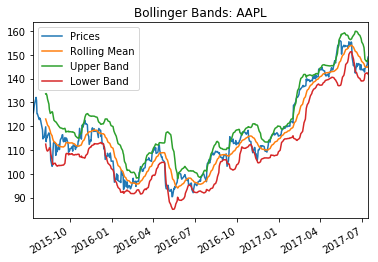

In [129]:
rolling_mean = get_rolling_mean(df_explore[ticker], window=20)
rolling_std = get_rolling_std(df_explore[ticker], window=20)
lower_band, upper_band = get_bollinger_bands(rolling_mean, rolling_std)

print_bollinger_bands(df_explore[ticker], rolling_mean, lower_band, upper_band, ticker)

## Daily Returns
---

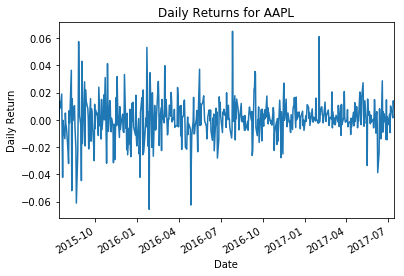

Max/Min Daily Returns for AAPL
Max: 0.0649632681279
Min: -0.0657065719713


In [130]:
daily_returns  = get_daily_returns(df_explore)
plot_data(daily_returns[ticker], title='Daily Returns for ' + ticker, xlabel='Date', ylabel='Daily Return')

print 'Max/Min Daily Returns for ' + ticker
print 'Max:', daily_returns[ticker].max()
print 'Min:', daily_returns[ticker].min()

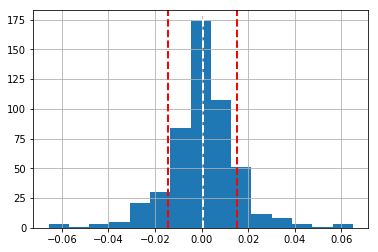

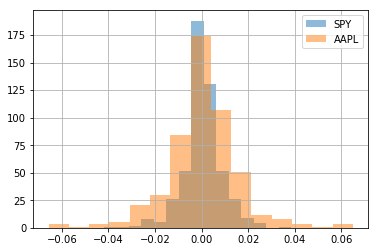

In [131]:
plot_hist_with_stats(daily_returns[ticker], bins=15, title=ticker)
plot_hist_multi(daily_returns, bins=15)

## Momentum
---

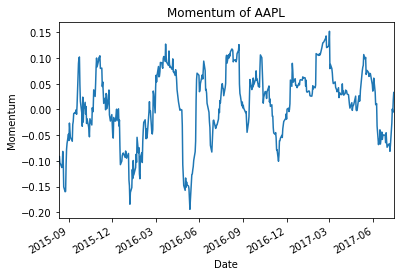

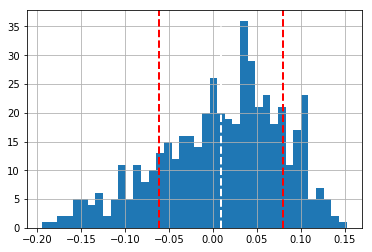

Max/Min Momentum for AAPL
Max: 0.151957110045
Min: -0.194112420948


In [132]:
# momentum at a 20 day window size. 
momentum = get_momentum(df_explore[ticker], window=20)

plot_data(momentum, title='Momentum of ' + ticker, xlabel='Date', ylabel='Momentum')
plot_hist_with_stats(momentum, bins=40, title=ticker)

print 'Max/Min Momentum for ' + ticker
print 'Max:', momentum.max()
print 'Min:', momentum.min()

## Simple Moving Average Ratio
---

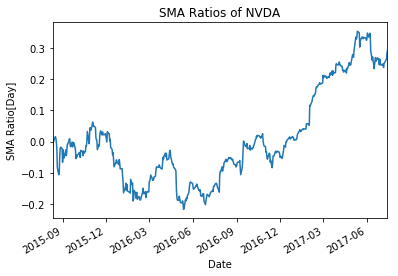

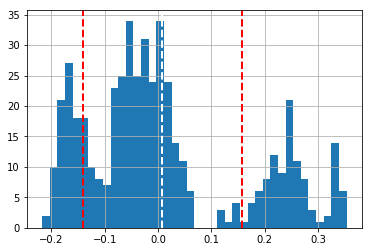

Max/Min SMA Ratio for AAPL
Max:  0.352929282604
Min:  -0.217017160276


In [133]:
sma_ratios = get_sma_ratio(df_explore[ticker])

plot_data(sma_ratios, title='SMA Ratios of NVDA', xlabel='Date', ylabel='SMA Ratio[Day]')
plot_hist_with_stats(sma_ratios, bins=40, title=ticker)

print 'Max/Min SMA Ratio for ' + ticker
print 'Max: ', sma_ratios.max()
print 'Min: ', sma_ratios.min()

## Bolinger Ratios
---

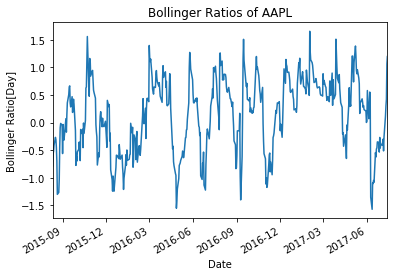

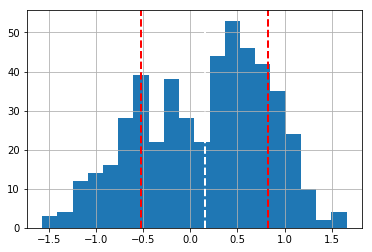

Max/Min BB Ratio for AAPL
Max: 1.6570687019
Min: -1.57259897343


In [134]:
bb_ratios = get_bollinger_ratios(df_explore[ticker], rolling_mean, rolling_std)

plot_data(bb_ratios, title='Bollinger Ratios of ' + ticker, xlabel='Date', ylabel='Bollinger Ratio[Day]')
plot_hist_with_stats(bb_ratios, bins=20, title=ticker)

print 'Max/Min BB Ratio for ' + ticker
print 'Max:', bb_ratios.max()
print 'Min:', bb_ratios.min()

## Correlations
---

Now that we have our features we are interested in, lets see how much they are correlated to eachother.


In [155]:
# recombine the features into a new Data Frame X and Y. 
# X will be a frame of all the featres for and Y will be the outcomes

d = { 'BB_RATIOS' : bb_ratios, 'SMA_RATIOS' : sma_ratios, 'MOMENTUM' : momentum }
features_df = pd.DataFrame(d)

X_features = features_df[0 : -1].values
y_target = df_explore[ticker][21 : ].values


print 'Features Length', len(X_features)
print 'Target Length', len(y_target)


Features Length 485
Target Length 485


## KNN
---

In [152]:
pipe_knn = Pipeline([
        ('scl', StandardScaler()),
        ('clf', KNeighborsRegressor(n_neighbors=5, weights='distance'))
    ])

tscv = TimeSeriesSplit(n_splits=3)
train_scores = []
test_scores = []

final_predics = []
actual_vals = []

for train_index, test_index in tscv.split(X_features):
    pipe_knn.fit(X_features[train_index], y_target[train_index])
    
    train_score = pipe_knn.score(X_features[train_index], y_target[train_index])
    test_score = pipe_knn.score(X_features[test_index], y_target[test_index])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    final_predic = pipe_knn.predict(X_features[test_index])
    actual_vals = y_target[test_index]
    #print '\nActual', y_target[test_index][0:1]
    #print 'Predicted', pipe_knn.predict(X_features[test_index][0:1])

print '\nTrain scores', train_scores
print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

print '\nTest scores', test_scores
print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

print '\nPredictions', final_predic[0: 12]

print '\nActual', actual_vals[0: 12]



Train scores [1.0, 1.0, 1.0]
Train Scores Mean 1.0, Train Scores STD 0.0

Test scores [-0.80265336084894146, 0.84801595079790371, -7.4416581274363445]
Test Scores Mean -2.46543184583, Test Scores STD 3.58267109835

Predictions [ 119.66159598  119.17873776  118.42605936  119.60859313  119.75501924
  119.76431795  118.99307389  118.59352917  120.77672766  121.13767477
  121.16800451  121.25614495]

Actual [ 120.080002  119.970001  121.879997  121.940002  121.949997  121.629997
  121.349998  128.75      128.529999  129.080002  130.289993  131.529999]


## Linear Regression 
---

In [151]:

pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LinearRegression())
    ])

tscv = TimeSeriesSplit(n_splits=3)
train_scores = []
test_scores = []

final_predics = []
actual_vals = []

for train_index, test_index in tscv.split(X_features):
    pipe_lr.fit(X_features[train_index], y_target[train_index])
    
    train_score = pipe_lr.score(X_features[train_index], y_target[train_index])
    test_score = pipe_lr.score(X_features[test_index], y_target[test_index])
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    final_predic = pipe_lr.predict(X_features[test_index])
    actual_vals = y_target[test_index]

print '\nTrain scores', train_scores
print 'Train Scores Mean {}, Train Scores STD {}'.format(np.asarray(train_scores).mean(), np.asarray(train_scores).std())

print '\nTest scores', test_scores
print 'Test Scores Mean {}, Test Scores STD {}'.format(np.asarray(test_scores).mean(), np.asarray(test_scores).std())

print '\nPredictions', final_predic[0: 12]

print '\nActual', actual_vals[0: 12]



Train scores [0.91437902751633937, 0.95377261616528464, 0.95905877003357431]
Train Scores Mean 0.942403471238, Train Scores STD 0.0199334382404

Test scores [0.92504653938318271, 0.92201984082277577, 0.95219126126524722]
Test Scores Mean 0.93308588049, Test Scores STD 0.0135659354502

Predictions [ 119.83313651  119.90192917  119.77666006  121.73145577  121.76603725
  121.75689153  121.41375489  121.1180604   128.58520855  128.29237778
  128.79773818  129.96674738]

Actual [ 120.080002  119.970001  121.879997  121.940002  121.949997  121.629997
  121.349998  128.75      128.529999  129.080002  130.289993  131.529999]


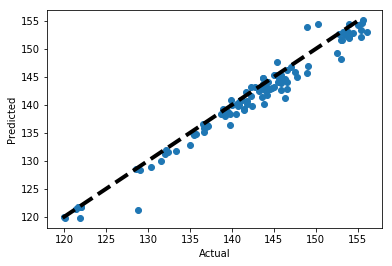

In [139]:
fig, ax = plt.subplots()
ax.scatter(actual_vals, final_predic)
ax.plot([final_predic.min(), final_predic.max()], [final_predic.min(), final_predic.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()